In [1]:
import pickle
import numpy as np
import pandas as pd

from geopy.distance import great_circle

import pygmo as pg

In [2]:
case = "Nepal"

# Load Pareto Front Perfect Information

In [3]:
# # Store data (serialize)
# with open('{}/MOO/rob_nondom_pols_test1.pickle'.format(case),
#           'wb') as handle:
#     pickle.dump(
#         (rob_nondom_pols),
#         handle,
#         protocol=pickle.HIGHEST_PROTOCOL)
    
with open('{}/MOO/rob_nondom_pols_test3_norobustnessfilter.pickle'.format(case),
          'rb') as handle:
    Full_Info_nondom_pols = pickle.load(
        handle)

In [4]:
Full_Info_nondom_pols.shape

(72,)

In [5]:
FullInf_FLs = np.array([[int(key[3:]) for key,value in pol.items() if value == 1] for pol in Full_Info_nondom_pols])

In [6]:
FullInf_FLs.shape

(72, 4)

# Load Policies proposed by MPMORDM

In [7]:
output_folder = "MPMORDM Results v1 2015"

In [8]:
with open('{}/{}/python_objects.pickle'.format(case, output_folder),
          'rb') as handle:
    global_label_tree, EMA_model_dict, global_dfs_var_unc_data, global_fixed_unc, global_policy_tree = pickle.load(
        handle)

In [9]:
p4_labels = global_label_tree['p4']

In [10]:
p4_pols = [global_policy_tree[label] for label in p4_labels]

In [11]:
p4_pols = np.array(p4_pols)

In [12]:
print("P4 after Multi-Period Robust Optimisation contains {} number of policies".format((p4_pols.shape)))

P4 after Multi-Period Robust Optimisation contains (1376,) number of policies


In [13]:
p4_FLs = np.array([[int(key[3:]) for key,value in pol.items() if value == 1] for pol in p4_pols])

In [14]:
p4_FLs.shape

(1376, 4)

In [15]:
# In total there are this many unique policies
len(np.unique(p4_FLs, axis=0))

207

# Codification 

## Codify y

In [16]:
mask_mpmordm_in_PF = [1 if pol_fls.tolist() in FullInf_FLs.tolist() else 0 for pol_fls in p4_FLs]

In [17]:
Data = pd.DataFrame(mask_mpmordm_in_PF, columns=['InPF_bool'], index=global_label_tree['p4'])

In [18]:
# Print Some info
p4_FLs_inPF = p4_FLs[mask_mpmordm_in_PF]

print(p4_FLs_inPF.shape)

print(
    "From all {} possible decision paths (MPMORDM), {} are inside the pareto optimal front for the actual values".
    format(p4_FLs.shape[0], p4_FLs[mask_mpmordm_in_PF].shape[0]))

Perc_Opt_Dec_Paths = (p4_FLs[mask_mpmordm_in_PF].shape[0] / p4_FLs.shape[0])*100

print("{0:.1f}% of all decision paths (MPMORDM) are in the Pareto Front".format(Perc_Opt_Dec_Paths))

(1376, 4)
From all 1376 possible decision paths (MPMORDM), 1376 are inside the pareto optimal front for the actual values
100.0% of all decision paths (MPMORDM) are in the Pareto Front


In [19]:
Data.tail()

,InPF_bool
p0n0p1n7p2n52p3n320p4n1692,0
p0n0p1n7p2n52p3n320p4n1693,0
p0n0p1n7p2n52p3n320p4n1694,0
p0n0p1n7p2n52p3n320p4n1695,0
p0n0p1n7p2n52p3n320p4n1696,1


## Get X data

In [20]:
# Helper functions From other Notebooks
"""From: Final Analysis 2 - Hypervolume for each mordmbranch vs uncertainty - Not Cleaned"""
def find_fl_placement_sequence(label):
    """Verificated"""
    max_ps = label.count("p")-1
    sequence = []
    cur_label = label
    while len(sequence) < max_ps:
        last_fl, prev_label = find_last_fl(cur_label)
        sequence.append(last_fl)
        cur_label = prev_label
    return list(reversed(sequence))

def find_last_fl(label):
    prev_label = find_previous_label(label)
    prev_perf = pd.read_csv("{}/{}/nondom_BE_pols{}.csv".format(case, output_folder, prev_label), index_col=0)
    cur_pol = global_policy_tree[label]
    cur_fls = policy_to_fls(cur_pol)
    for fl in cur_fls:
        if fl in prev_perf.index:
            return fl, prev_label
    raise ValueError("Something went wrong")

def find_previous_label(label):
    for i,l in enumerate(label[::-1]):
        if l == "p":
            return label[:-i-1]
        
def policy_to_fls(pol):
    return [int(key[3:]) for key, val in pol.items() if val == 1]

In [21]:
global_label_tree['p4'][-1]

'p0n0p1n7p2n52p3n320p4n1696'

In [22]:
# test_fl_sequence = find_fl_placement_sequence('p0n0p1n7p2n52p3n320p4n1696')

In [23]:
# test_label_sequence = find_previous_labels('p0n0p1n7p2n52p3n320p4n1696')

In [24]:
def find_previous_labels(label):
    labels = []
    last_label = label
    while True:
        labels.append(last_label)
        last_label = find_previous_label(last_label)
        if len(last_label) == 0:
            return labels
        

In [25]:
# list(zip(test_fl_sequence,reversed(test_label_sequence)))

In [26]:
# test = Data.iloc[0]

In [27]:
# test.name

In [28]:
def get_performance_all_p (label):
    tmp_fl_sequence = find_fl_placement_sequence(label)
    tmp_label_sequence = find_previous_labels(label)
    all_period_perf = pd.DataFrame()
    for fl, lab in zip(tmp_fl_sequence,reversed(tmp_label_sequence)):
#         print('fl',fl,'lab',lab)
        tmp_perf = pd.read_csv("{}/{}/nondom_BE_pols{}.csv".format(case, output_folder, lab), index_col=0).loc[fl]
        all_period_perf = pd.concat([all_period_perf, tmp_perf])
    
    
    all_period_perf = all_period_perf.T
#     all_period_perf.columns = 
    return all_period_perf.values[0]
        
    

In [29]:
get_performance_all_p("p0n0p1n1p2n8p3n53p4n323")

array([7.29270615e+04, 2.90000000e+01, 3.29655900e+04, 9.16519500e+04,
       6.84130459e+04, 2.80000000e+01, 3.26353265e+04, 6.75992170e+04,
       2.83650217e+05, 1.40000000e+01, 8.61744550e+03, 5.85409368e+04,
       2.75848344e+05, 1.30000000e+01, 9.38007728e+03, 3.87554950e+04])

In [30]:
test1 = Data.apply(lambda row: get_performance_all_p(row.name), axis=1)

In [31]:
test2 = np.vstack(test1.values)

In [32]:
test3 = pd.DataFrame(test2)

In [33]:
test3.columns = ['total_costs_p1', 'nr_uncovered_DPs_p1', 'total_uncovered_demand_p1',
       'max_distr_time_p1', 'total_costs_p2', 'nr_uncovered_DPs_p2',
       'total_uncovered_demand_p2', 'max_distr_time_p2', 'total_costs_p3',
       'nr_uncovered_DPs_p3', 'total_uncovered_demand_p3', 'max_distr_time_p3',
       'total_costs_p4', 'nr_uncovered_DPs_p4', 'total_uncovered_demand_p4',
       'max_distr_time_p4']

In [34]:
test3.index = Data.index

In [35]:
Data2 = pd.merge(Data, test3, left_index=True, right_index=True)

# Heuristics Analysis

In [36]:
# import prim

In [37]:
x = Data2.iloc[:,1:].reset_index(drop=True)
y = Data2.iloc[:,0]

In [38]:
x = x.to_records()
y = y.values

In [39]:
# import matplotlib
# %matplotlib inline

In [40]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [41]:
from ema_workbench.analysis import prim
from ema_workbench import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)



C:\Users\timro\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


<Logger EMA (DEBUG)>

In [42]:
prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.048)


In [43]:
box1 = prim_alg.find_box()

[MainProcess/INFO] 1376 points remaining, containing 692 cases of interest
C:\Users\timro\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
[MainProcess/INFO] mean: 0.8679245283018868, mass: 0.07703488372093023, coverage: 0.1329479768786127, density: 0.8679245283018868 restricted_dimensions: 10


In [44]:
# # Store data (serialize)
# with open('testprimbox1and0_2.pickle',
#           'wb') as handle:
#     pickle.dump(
#         (prim_alg, box1),
#         handle,
#         protocol=pickle.HIGHEST_PROTOCOL)

<IPython.core.display.Javascript object>


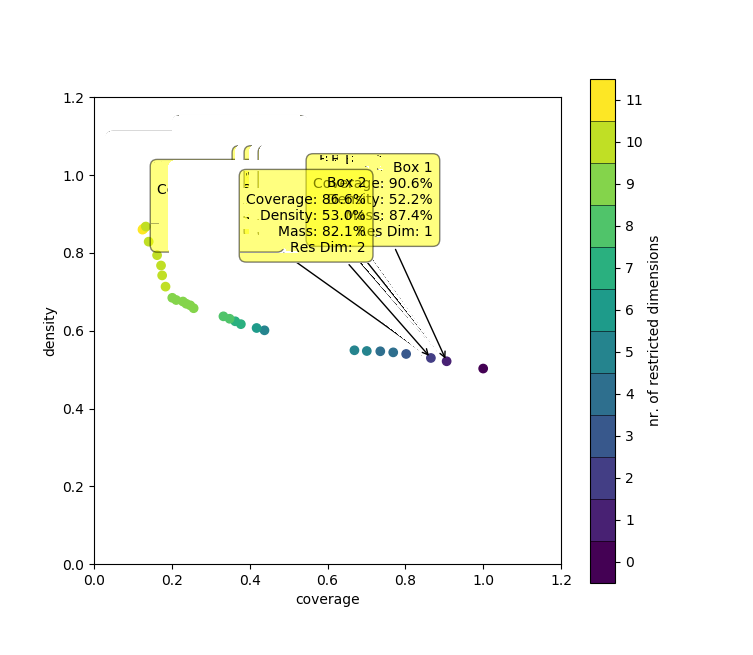

In [49]:
box1.show_tradeoff()
plt.show()

In [106]:
plt.show()

In [51]:
box1.inspect(1)

coverage    0.906069
density     0.521631
mass        0.873547
mean        0.521631
res dim            1
Name: 1, dtype: object

                      box 1                                      
                        min            max              qp values
total_costs_p1  7952.041135  206664.527518  [0.10212101246809148]



<IPython.core.display.Javascript object>


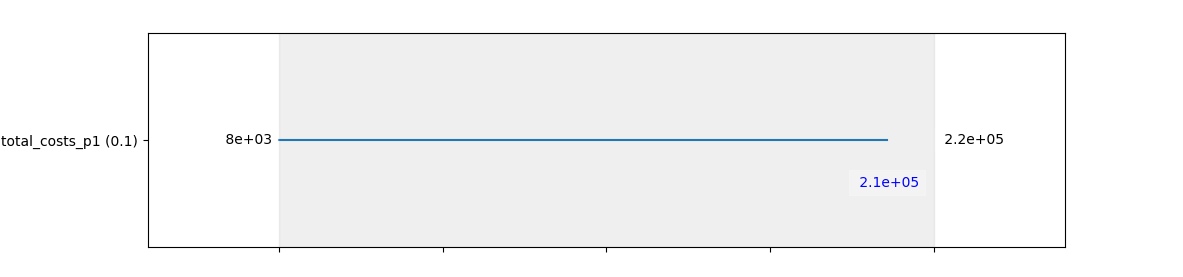

In [54]:
box1.inspect(1,style='graph')
plt.show()

In [87]:
box1.select(20)

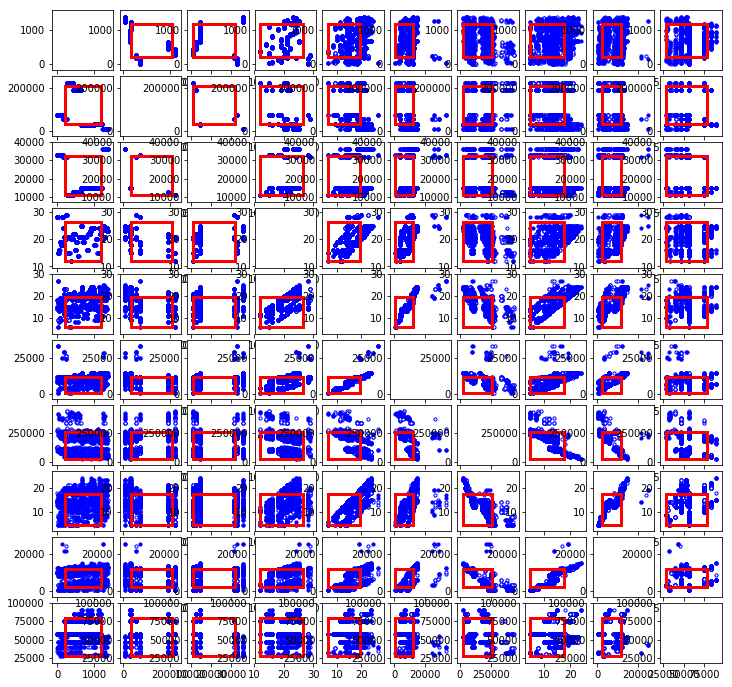

In [88]:
fig = box1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()

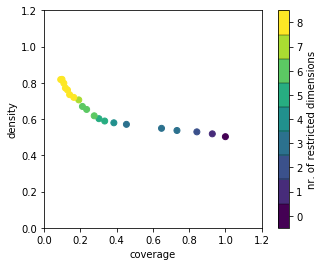

In [68]:
box1.show_tradeoff()
plt.show()

In [69]:
box2 = prim_alg.find_box()

[MainProcess/INFO] 1293 points remaining, containing 624 cases of interest
C:\Users\timro\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
[MainProcess/INFO] mean: 0.9054054054054054, mass: 0.05377906976744186, coverage: 0.0968208092485549, density: 0.9054054054054054 restricted_dimensions: 11


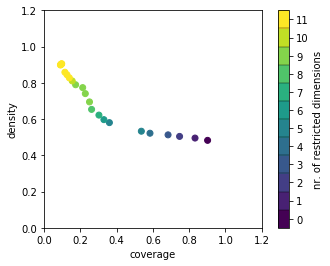

In [70]:
box2.show_tradeoff()
plt.show()

In [71]:
box3 = prim_alg.find_box()

[MainProcess/INFO] 1219 points remaining, containing 557 cases of interest
C:\Users\timro\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
[MainProcess/INFO] mean: 0.8840579710144928, mass: 0.0501453488372093, coverage: 0.08815028901734104, density: 0.8840579710144928 restricted_dimensions: 5


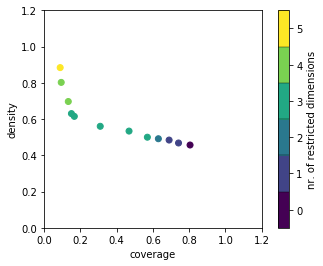

In [72]:
box3.show_tradeoff()
plt.show()